<a href="https://colab.research.google.com/github/sanjivan7/G-T-A/blob/main/Gold_Trade_Advisor_(CMII).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
Team: Crystal Math
Project Title: Gold Trade Advisor

Project Brief:
- Create a gold stock price predictor
- Based on prediction, find suitable time to buy or sell gold stock
- Prompt user to buy or sell stock to gain max profit
```


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras

# used to separate the datasets into training sets and predict test
from sklearn.model_selection import train_test_split
import datetime as dt

In [ ]:
# Import dataset
url = 'https://raw.githubusercontent.com/mzisyraf/GoldStockAdvisor/main/monthly_csv.csv'
df = pd.read_csv(url)

# View dataset
display(df)

,Date,Price
0,1950-01,34.730
1,1950-02,34.730
2,1950-03,34.730
3,1950-04,34.730
4,1950-05,34.730
...,...,...
842,2020-03,1593.764
843,2020-04,1680.030
844,2020-05,1715.697
845,2020-06,1734.032


In [ ]:
df.dtypes

Date      object
Price    float64
dtype: object

In [ ]:
# Scale data between 0 and 1
# Data is scaled in order to improve stability and performance of model

#copy data
df_scaled = df.copy()
# apply normalization techniques to Price column
column = 'Price'
df_scaled[column] = (df_scaled[column] - df_scaled[column].min()) / (df_scaled[column].max() - df_scaled[column].min())

# view normalized data
display(df_scaled)


,Date,Price
0,1950-01,0.000133
1,1950-02,0.000133
2,1950-03,0.000133
3,1950-04,0.000133
4,1950-05,0.000133
...,...,...
842,2020-03,0.863234
843,2020-04,0.910992
844,2020-05,0.930738
845,2020-06,0.940888


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df_scaled['Date'] = pd.to_datetime(df_scaled['Date'])
df_scaled['Date'] = df_scaled['Date'].map(dt.datetime.toordinal)
df_scaled['Date'] = pd.to_numeric(df_scaled['Date'])
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    847 non-null    int64  
 1   Price   847 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 13.4 KB


In [ ]:
display(df_scaled)

,Date,Price
0,711858,0.000133
1,711889,0.000133
2,711917,0.000133
3,711948,0.000133
4,711978,0.000133
...,...,...
842,737485,0.863234
843,737516,0.910992
844,737546,0.930738
845,737577,0.940888


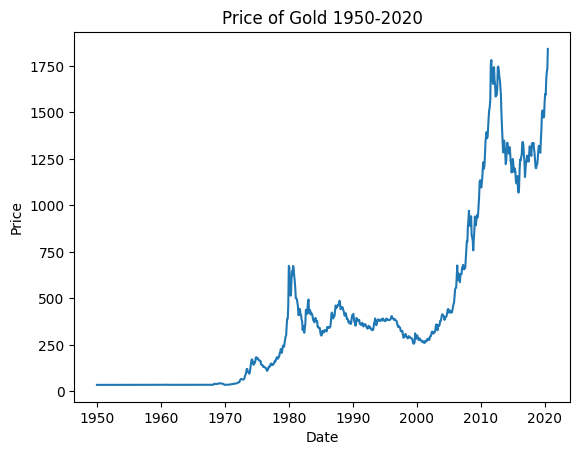

In [ ]:
# Plot dataset

plt.plot(df['Date'], df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price of Gold 1950-2020')
plt.show()

In [ ]:
# Option 1

X = df_scaled['Date'].to_numpy()
y = np.squeeze(df_scaled['Price'].to_numpy())


#Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = np.stack([np.ones(X_train.shape[0]), X_train], axis=1)

In [ ]:
# Option 2

# Split dataset into training and testing set

train, test = train_test_split(df_scaled, test_size=0.2)

# Sort data by date
train = train.sort_values(by = 'Date')
test = test.sort_values(by = 'Date')
train

,Date,Price
0,711858,0.000133
1,711889,0.000133
2,711917,0.000133
3,711948,0.000133
4,711978,0.000133
...,...,...
841,737456,0.866032
842,737485,0.863234
843,737516,0.910992
844,737546,0.930738


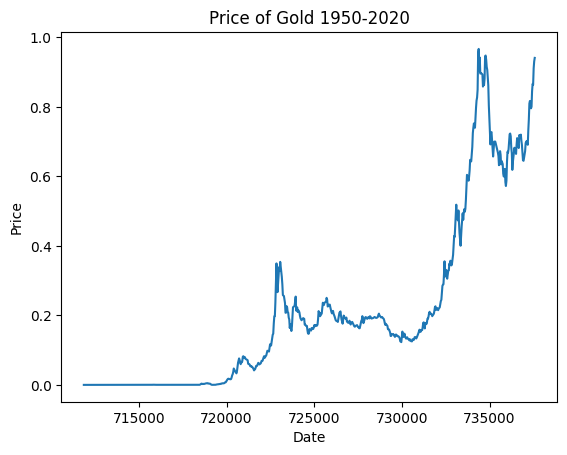

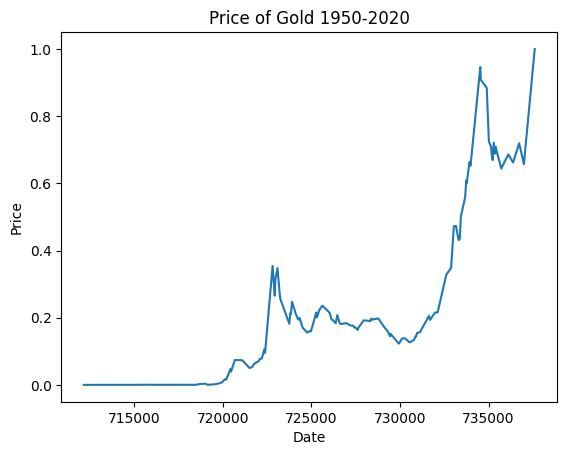

In [ ]:
# Plot training data

plt.plot(train['Date'], train['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price of Gold 1950-2020')
plt.show()

# Plot testing data

plt.plot(test['Date'], test['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price of Gold 1950-2020')
plt.show()

In [ ]:
# FROM HERE FORWARD EVERYTHING IS JUST A TEST !


seq_len = 60

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(df_scaled, seq_len, train_frac=0.9)

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True,
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
))

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
)

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))


In [ ]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/10
36/36 [==============================] - 19s 228ms/step - loss: 260839899136.0000 - val_loss: 268675006464.0000
Epoch 2/10
36/36 [==============================] - 5s 135ms/step - loss: 260833361920.0000 - val_loss: 268671107072.0000
Epoch 3/10
36/36 [==============================] - 5s 133ms/step - loss: 260829806592.0000 - val_loss: 268667568128.0000
Epoch 4/10
36/36 [==============================] - 4s 110ms/step - loss: 260826349568.0000 - val_loss: 268664127488.0000
Epoch 5/10
36/36 [==============================] - 4s 122ms/step - loss: 260823040000.0000 - val_loss: 268660883456.0000
Epoch 6/10
36/36 [==============================] - 4s 117ms/step - loss: 260819812352.0000 - val_loss: 268657541120.0000
Epoch 7/10
36/36 [==============================] - 4s 109ms/step - loss: 260816535552.0000 - val_loss: 268654264320.0000
Epoch 8/10
36/36 [==============================] - 5s 130ms/step - loss: 260813307904.0000 - val_loss: 268651020288.0000
Epoch 9/10
36/36 [=====

3/3 [==============================] - 0s 73ms/step


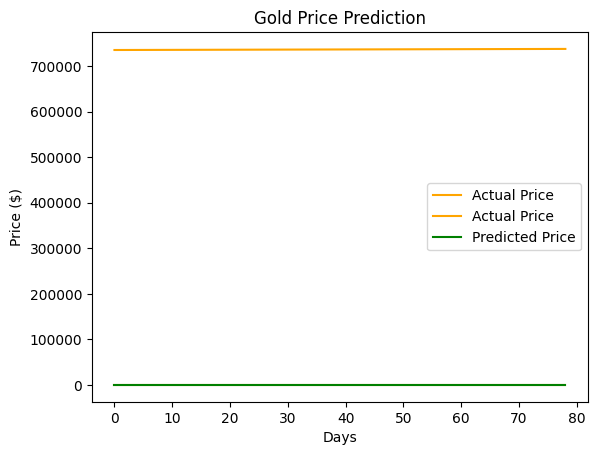

In [ ]:
y_pred = model.predict(x_test)


# plots of prediction against actual data
plt.plot(y_test, label='Actual Price', color='orange')
plt.plot(y_pred, label='Predicted Price', color='green')

plt.title('Gold Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend(loc='best')

plt.show();